In [1]:
import numpy as np 

import firtez_dz as frz
import matplotlib.pyplot as plt 

In [2]:
atm = frz.read_model("/home/milic/data/scratch/out_guess_step_2.bin")

In [3]:
atm.tem.shape

(601, 215, 64)

In [4]:
atm.tau.shape

(601, 215, 64)

In [5]:
atm.tau[0,0]

array([ 1.10712111,  0.77756107,  0.47014254,  0.19913812, -0.03430894,
       -0.23857428, -0.42262235, -0.59326094, -0.75573987, -0.91398776,
       -1.0707221 , -1.22766864, -1.38588583, -1.54606259, -1.70859849,
       -1.87364662, -2.04123378, -2.21131611, -2.38371825, -2.55812311,
       -2.73413205, -2.91120219, -3.08845329, -3.26461649, -3.43821001,
       -3.60748124, -3.7698226 , -3.92124915, -4.05669975, -4.17166376,
       -4.26489782, -4.33973646, -4.40195847, -4.45656395, -4.50646782,
       -4.55291843, -4.59630489, -4.63674593, -4.67428875, -4.70908737,
       -4.7418232 , -4.77357769, -4.80519485, -4.83713627, -4.86965513,
       -4.90285492, -4.93679333, -4.97162247, -5.0075922 , -5.04500437,
       -5.08424568, -5.12583494, -5.1704154 , -5.21873713, -5.27173805,
       -5.33029747, -5.39464855, -5.46483994, -5.54193354, -5.62830925,
       -5.72789621, -5.84756851, -6.00096607, -6.22184896])

In [6]:
# Let's interpolate stuff

In [7]:
tau_new = np.linspace(-5,0,51)
NZ_new = len(tau_new)

In [8]:
NX,NY,NZ = atm.tau.shape

In [9]:
# We need T, p, vz, Btot, inc
atm_new = np.zeros([5, NX, NY, NZ_new])

In [10]:
btot = np.sqrt(atm.bz**2.0 + atm.bx**2.0 + atm.by**2.0)
inc = np.arccos(atm.bz / (btot + 1.0))

In [11]:
from tqdm import tqdm

In [12]:
for i in tqdm(range(0,NX)):
    for j in range(0,NY):
        atm_new[0,i,j,:] = np.interp(tau_new, atm.tau[i,j,::-1], atm.tem[i,j,::-1])
        atm_new[1,i,j,:] = np.interp(tau_new, atm.tau[i,j,::-1], atm.vz[i,j,::-1])
        atm_new[2,i,j,:] = np.interp(tau_new, atm.tau[i,j,::-1], btot[i,j,::-1])
        atm_new[3,i,j,:] = np.interp(tau_new, atm.tau[i,j,::-1], inc[i,j,::-1])
        atm_new[4,i,j,:] = np.interp(tau_new, atm.tau[i,j,::-1], atm.pg[i,j,::-1])
    #print (i)
        

100%|██████████████████████████████████████████████████████████████████████| 601/601 [00:01<00:00, 373.11it/s]


In [13]:
atm_new.shape

(5, 601, 215, 51)

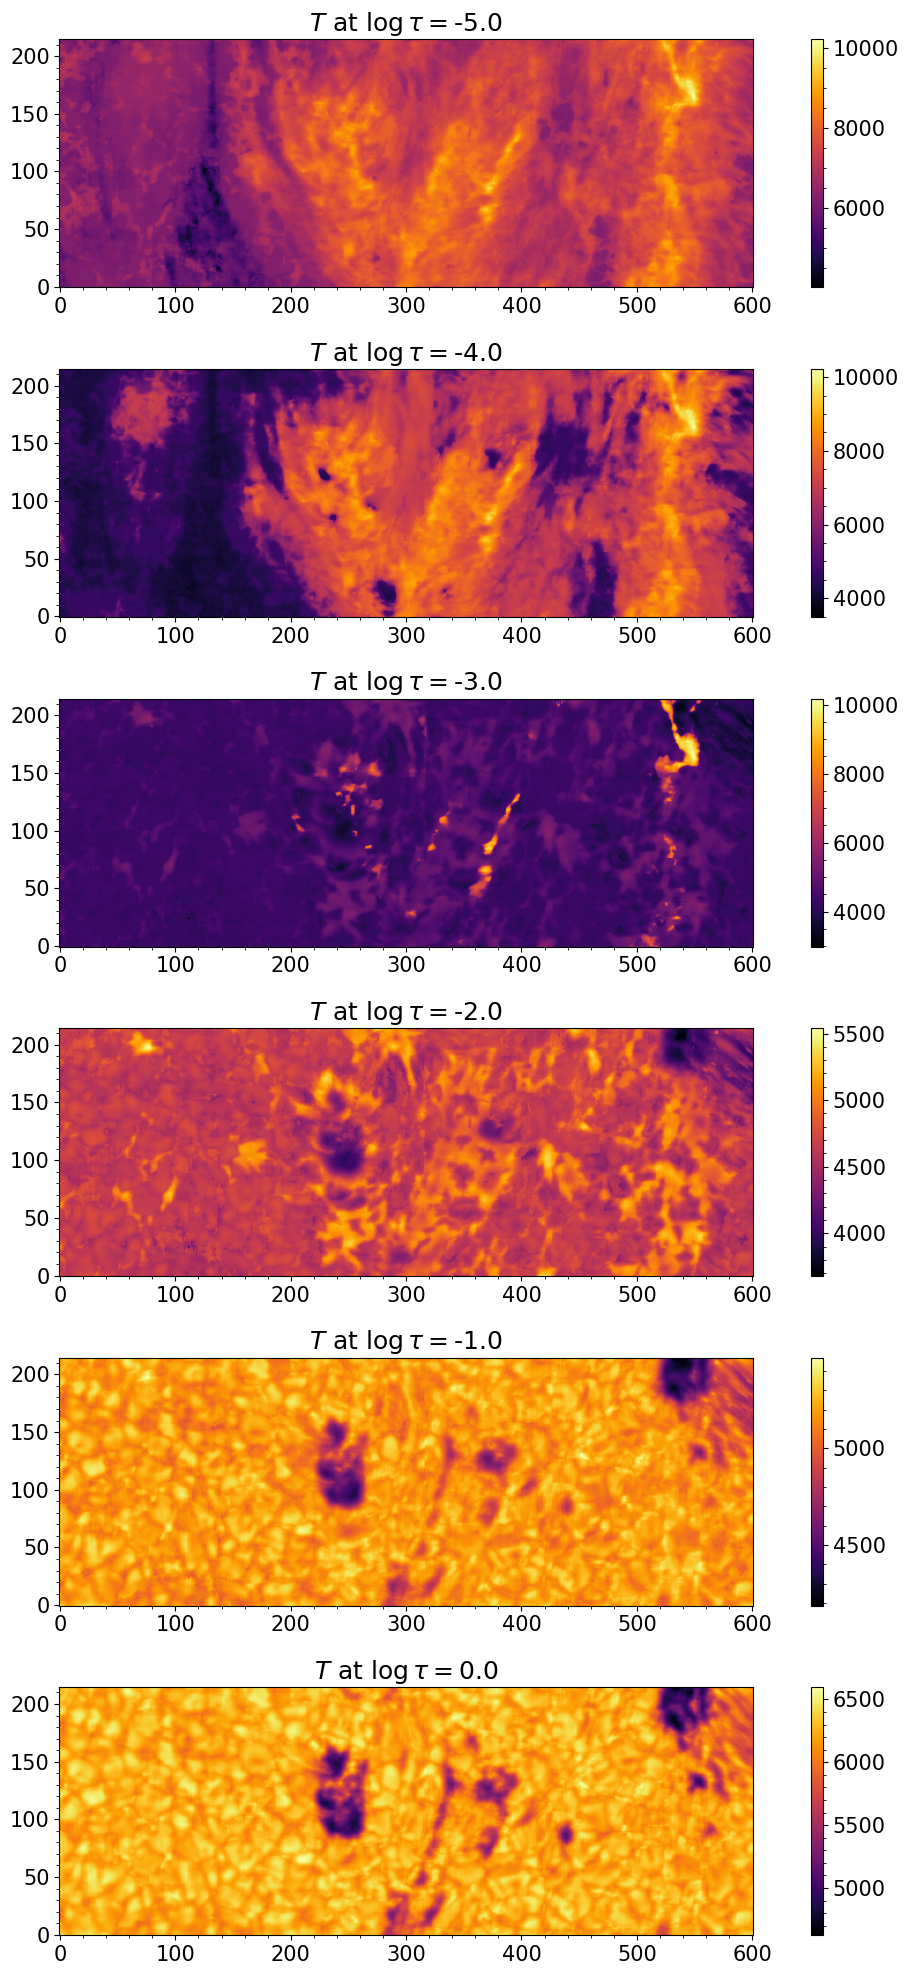

In [48]:
plt.figure(figsize=[12,20])
for d  in range(0,51,10):
    plt.subplot(6,1,d//10+1)
    plt.imshow(atm_new[0,:,:,d].T, cmap = 'inferno', origin='lower')
    plt.colorbar()
    plt.title("$T$ at $\log\\tau = $" + str(tau_new[d]))
plt.savefig("T_plts.png", bbox_inches='tight')
plt.tight_layout()

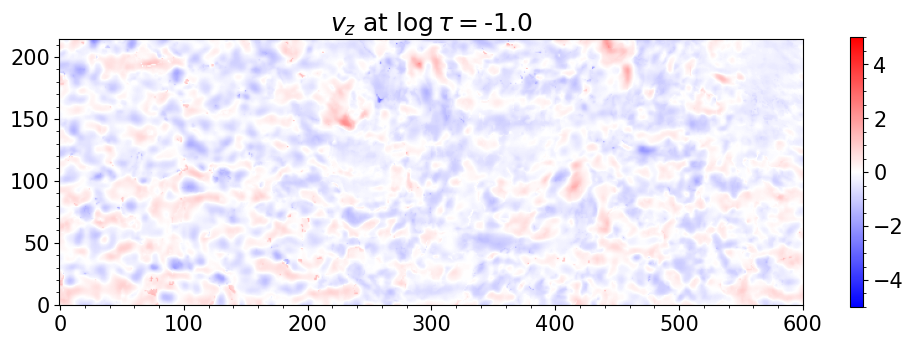

In [46]:
d = -11
plt.figure(figsize=[12,3.5])
plt.imshow(atm_new[1,:,:,d].T/1E5 + 0.1, cmap = 'bwr', origin='lower', vmin=-5,vmax=5)
plt.colorbar()
plt.title("$v_z$ at $\log\\tau = $" + str(tau_new[d]))
plt.savefig("vz_photo.png", bbox_inches='tight')

In [16]:
vzmean = np.mean(atm_new[1,:100,:100,-1])
print (vzmean/1E5)

-0.09627394121586227


In [ ]:
# To cluster, we are gonna normalize these vectors somehow. 

In [17]:
atm_new_vector = np.copy(atm_new)

In [18]:
for p in range(0,5):
    atm_new_vector[p] = (atm_new[p] - np.amin(atm_new[p])) / (np.amax(atm_new[p]) - np.amin(atm_new[p]))

In [19]:
from sklearn.cluster import KMeans

In [20]:
atm_new_vector = atm_new_vector[:,:,:,::10]

In [21]:
atm_new_vector.shape

(5, 601, 215, 6)

In [22]:
atm_new_vector = atm_new_vector.transpose(1,2,0,3)

In [23]:
atm_new_vector = atm_new_vector.reshape(601*215, 5*6)

In [24]:
atm_new_vector.shape

(129215, 30)

In [53]:
k_means = KMeans(init="k-means++", n_clusters=5, n_init="auto")
k_means.fit(atm_new_vector[:,3:6])

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [54]:
k_means.labels_.shape

(129215,)

In [55]:
labelihnos = k_means.labels_.reshape(601,215)

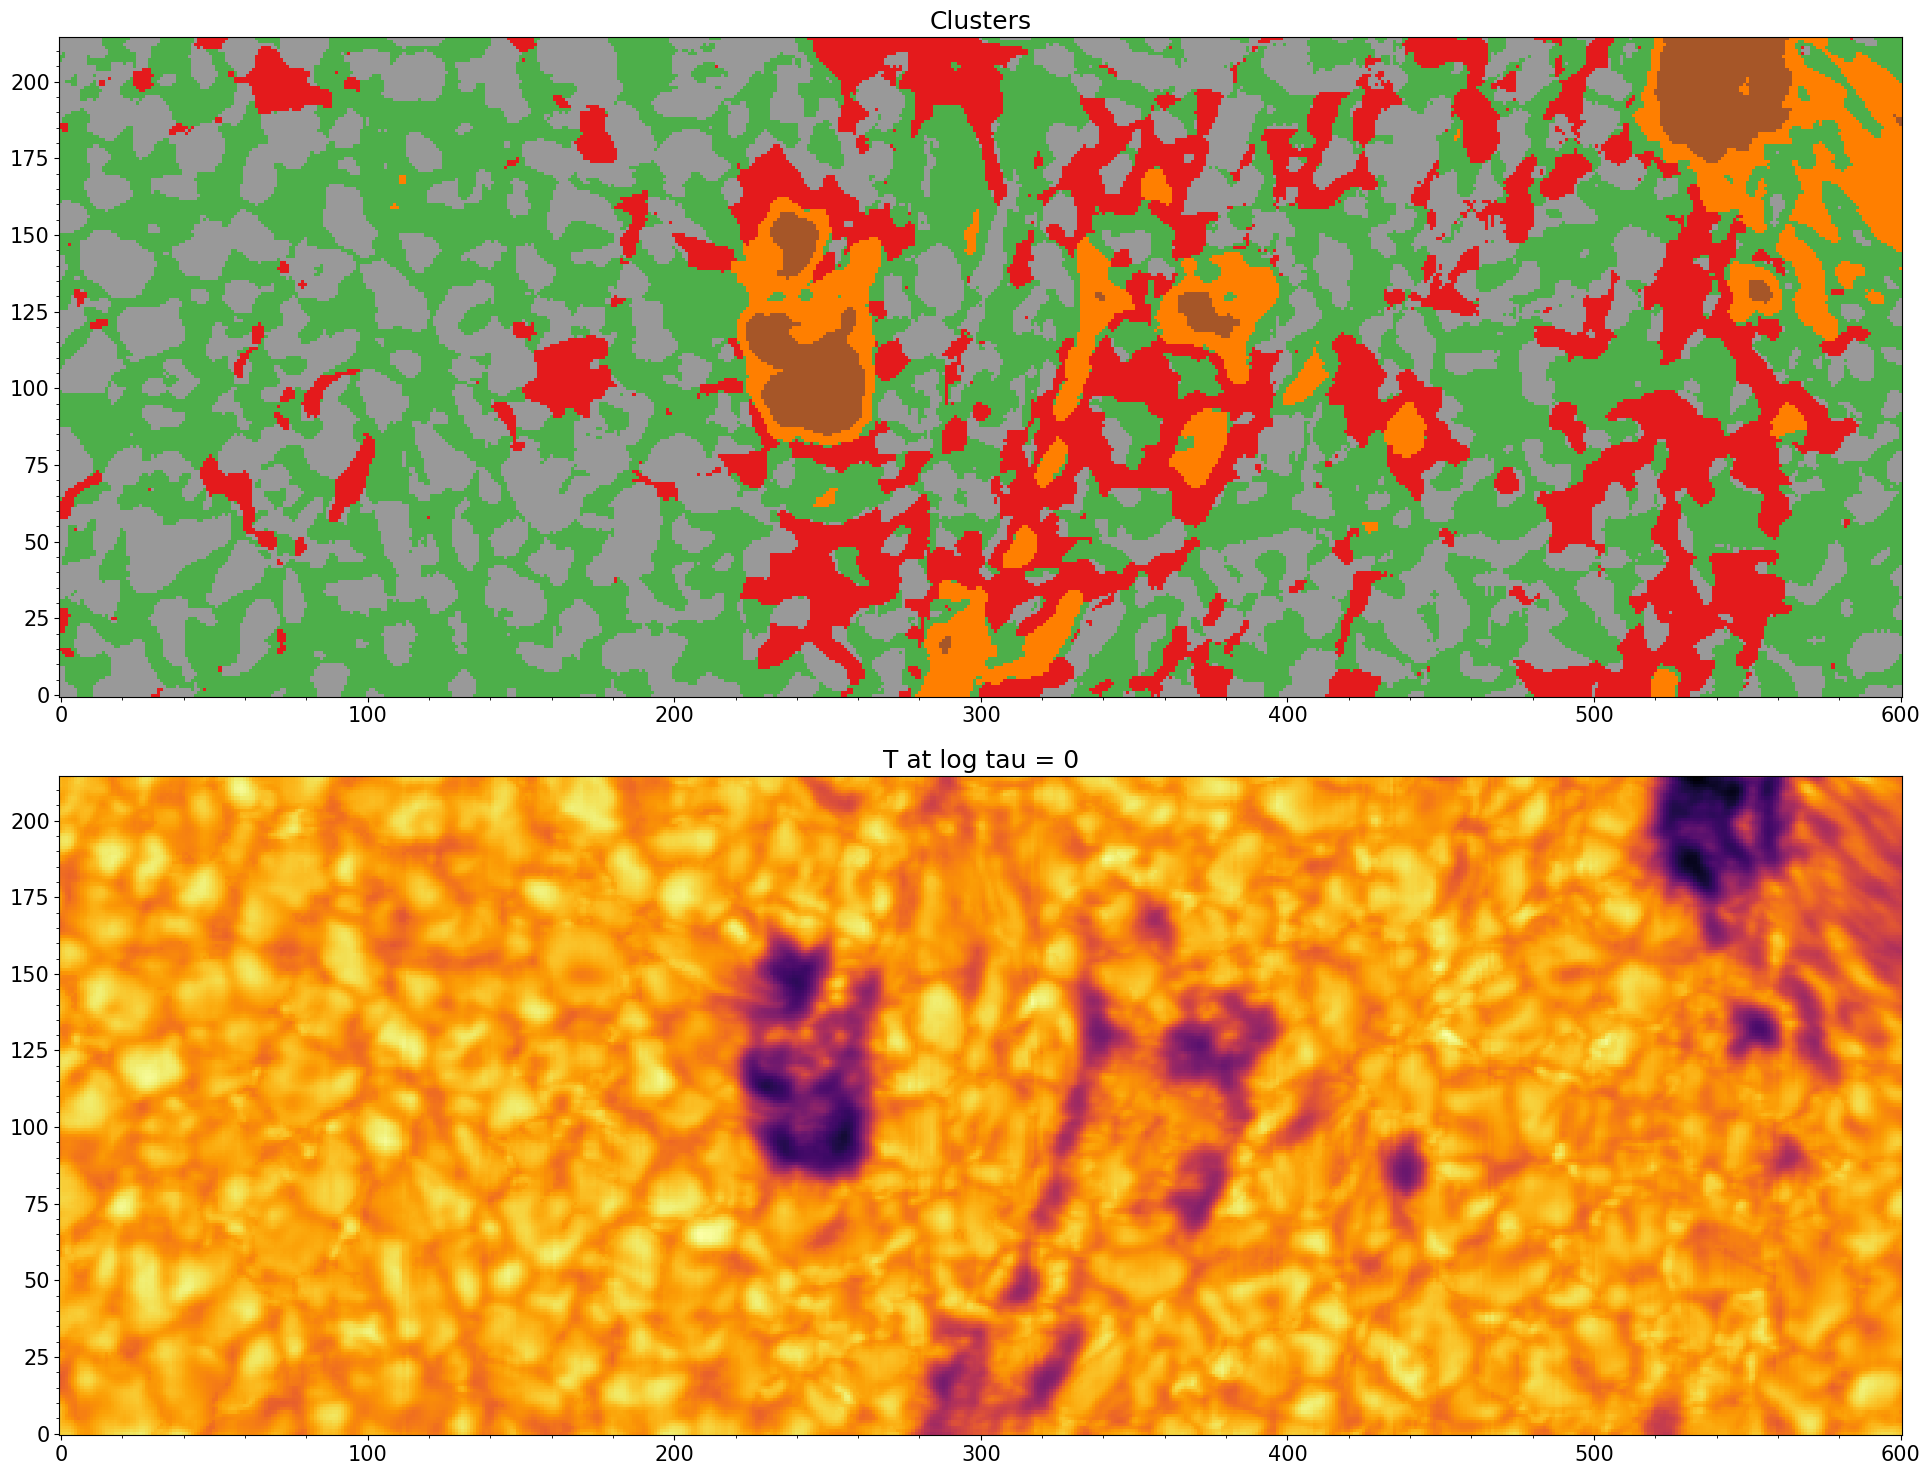

In [155]:
plt.figure(0,(25,15))
plt.subplot(2,1,1)
plt.imshow(labelihnos.T, origin='lower', cmap='Set1')
# plt.imshow(atm_new[0,:,:,-5].T, cmap = 'inferno', origin='lower', alpha=0.5)
plt.title("Clusters")
plt.subplot(2,1,2)
plt.imshow(atm_new[0,:,:,-5].T, cmap = 'inferno', origin='lower')
plt.title("T at log tau = 0")
plt.tight_layout()
# plt.colorbar()
plt.savefig("clusters.png",bbox_inches='tight')

In [134]:
## Create some mean, snapi format atmospheres from these labels and the original firtez atmospher

mean_atms = np.zeros([12,5,1,64])
mean_atms[0,:,:,:] = np.linspace(0.3,-6.0,64)[None,None,:]
mean_atms[1,:,:,:] = np.copy(atm.z[0,0,:][None,None,:])*1E5

for l in range(0,5):

    choice = np.where(labelihnos == l)
    # we are only going to average T and p, the rest can be zero!
    to_average = atm.tem[choice][:]
    mean_atms[2,l,0,:] = np.mean(to_average,axis=0)
    to_average = atm.pg[choice][:]
    mean_atms[3,l,0,:] = np.mean(to_average,axis=0)


mean_atms[4,:,:,:] = 0.01 * mean_atms[3,:,:,:]
    

In [135]:
mean_atms.shape

(12, 5, 1, 64)

In [147]:
falc = np.loadtxt("falc.dat",unpack=True, skiprows=1)
falc.shape

(12, 57)

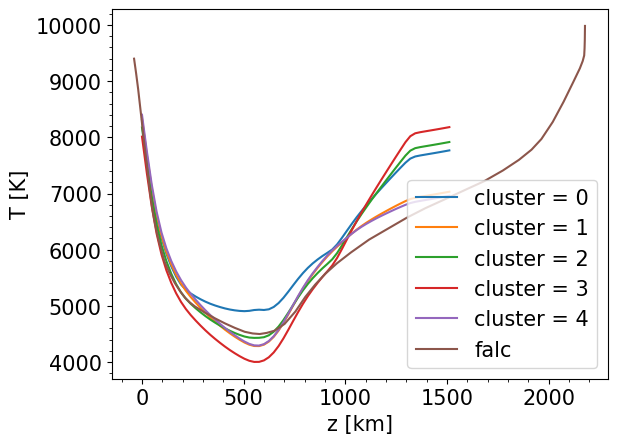

In [156]:
for l in range(0,5):
    plt.plot(mean_atms[1,l,0,:]/1E5, mean_atms[2,l,0,:], label = 'cluster = '+str(l))
    plt.xlabel("z [km]")
    plt.ylabel("T [K]")
plt.plot(falc[1,:]/1E5+60, falc[2,:], label='falc')
plt.legend()
plt.savefig("mean_T.png")


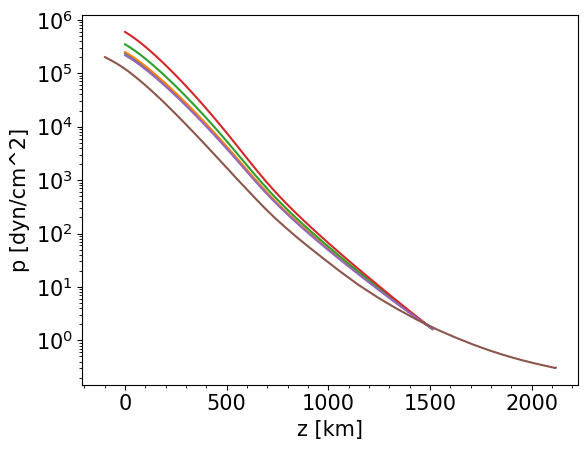

In [149]:
for l in range(0,5):
    plt.semilogy(mean_atms[1,l,0,:]/1E5, mean_atms[3,l,0,:])
    plt.xlabel("z [km]")
    plt.ylabel("p [dyn/cm^2]")
plt.semilogy(falc[1,:]/1E5, falc[3,:])
plt.savefig("mean_p.png")


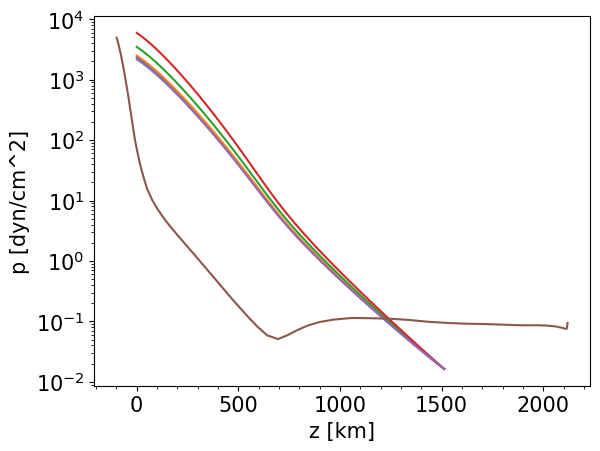

In [150]:
for l in range(0,5):
    plt.semilogy(mean_atms[1,l,0,:]/1E5, mean_atms[4,l,0,:])
    plt.xlabel("z [km]")
    plt.ylabel("p [dyn/cm^2]")
plt.semilogy(falc[1,:]/1E5, falc[4,:])
plt.savefig("mean_T.png")

In [151]:
# technical stuff not to break the synth code
mean_atms[-2,:,:,:] = 0.5
mean_atms[-1,:,:,:] = 0.5

In [140]:
from astropy.io import fits
kek = fits.PrimaryHDU(mean_atms[:,:,:,::-1])
kek.writeto("scip_5_clusters.fits",overwrite=True)

In [115]:

# ------------ run the syntesis --------------


In [141]:
spectra = fits.open("/home/milic/data/snapi_synth/scip_5_clusters_caII_ir.fits")[0].data

In [142]:
spectra.shape

(5, 1, 4, 1201)

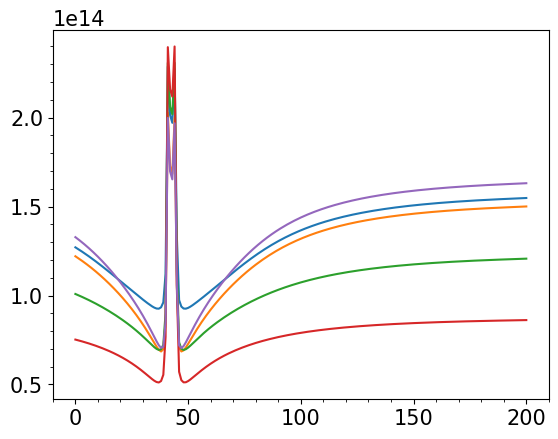

In [152]:
for l in range(0,5):
    plt.plot(spectra[l,0,0,1000:])
plt.savefig("ca_8542.png", bbox_inches='tight')